# Regrid between rectilinear grids


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe

## Prepare data


### Input data


We regrid xarray's built-in demo data. This data is also used by
[xarray plotting tutorial](http://xarray.pydata.org/en/stable/plotting.html).


In [2]:
ds = xr.tutorial.open_dataset(
    "air_temperature"
)  # use xr.tutorial.load_dataset() for xarray<v0.11.0
ds

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

It is the air temperature data over US with 2920 time frames. Let's plot the
first frame:


In [3]:
dr = ds["air"]  # get a DataArray

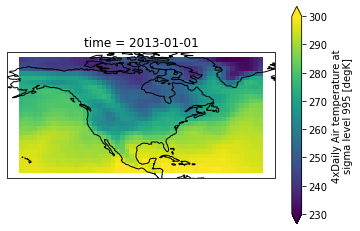

In [4]:
ax = plt.axes(projection=ccrs.PlateCarree())
dr.isel(time=0).plot.pcolormesh(ax=ax, vmin=230, vmax=300)
ax.coastlines()

### Input grid


Its grid resolution is $2.5^\circ \times 2.5^\circ$:


In [5]:
ds["lat"].values, ds["lon"].values

(array([75. , 72.5, 70. , 67.5, 65. , 62.5, 60. , 57.5, 55. , 52.5, 50. ,
        47.5, 45. , 42.5, 40. , 37.5, 35. , 32.5, 30. , 27.5, 25. , 22.5,
        20. , 17.5, 15. ], dtype=float32),
 array([200. , 202.5, 205. , 207.5, 210. , 212.5, 215. , 217.5, 220. ,
        222.5, 225. , 227.5, 230. , 232.5, 235. , 237.5, 240. , 242.5,
        245. , 247.5, 250. , 252.5, 255. , 257.5, 260. , 262.5, 265. ,
        267.5, 270. , 272.5, 275. , 277.5, 280. , 282.5, 285. , 287.5,
        290. , 292.5, 295. , 297.5, 300. , 302.5, 305. , 307.5, 310. ,
        312.5, 315. , 317.5, 320. , 322.5, 325. , 327.5, 330. ],
       dtype=float32))

### Output grid


Say we want to downsample it to $1.0^\circ \times 1.5^\circ$. Just define the
output grid as an xarray `Dataset`:


In [6]:
ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(16, 75, 1.0)),
        "lon": (["lon"], np.arange(200, 330, 1.5)),
    }
)
ds_out

<xarray.Dataset>
Dimensions:  (lat: 59, lon: 87)
Coordinates:
  * lat      (lat) float64 16.0 17.0 18.0 19.0 20.0 ... 70.0 71.0 72.0 73.0 74.0
  * lon      (lon) float64 200.0 201.5 203.0 204.5 ... 324.5 326.0 327.5 329.0
Data variables:
    *empty*

## Perform regridding


Make a regridder by `xe.Regridder(grid_in, grid_out, method)`. `grid` is just an
xarray `DataSet` containing `lat` and `lon` values. In most cases, `'bilinear'`
should be good enough. For other methods see
[Comparison of 5 regridding algorithms](./Compare_algorithms.ipynb).


In [7]:
regridder = xe.Regridder(ds, ds_out, "bilinear")
regridder  # print basic regridder information.

xESMF Regridder 
Regridding algorithm:       bilinear 
Input grid shape:           (25, 53) 
Output grid shape:          (59, 87) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

The regridder says it can transform data from shape `(25, 53)` to shape
`(59, 87)`.

Regrid the `DataArray` is straightforward:


In [8]:
dr_out = regridder(dr)
dr_out

<xarray.DataArray 'air' (time: 2920, lat: 59, lon: 87)>
array([[[296.13399675, 296.38669304, 296.63889823, ..., 296.47490793,
         296.43398913, 296.19924566],
        [295.97800871, 296.18274797, 296.42534501, ..., 296.09262341,
         296.07802394, 295.72098714],
        [296.04001766, 296.13556275, 296.30247974, ..., 295.77692914,
         295.73997197, 295.35693248],
        ...,
        [245.04017912, 245.36087049, 245.56096188, ..., 233.93629106,
         235.51802332, 238.0780694 ],
        [243.27991042, 243.77519503, 244.17375053, ..., 233.81591274,
         235.33999633, 237.63241841],
        [242.24003289, 242.87912303, 243.43775032, ..., 233.84791841,
         235.41999207, 237.49641598]],

       [[296.25399643, 296.70203773, 297.03166485, ..., 296.06514956,
         296.03998263, 296.01773136],
        [296.2179898 , 296.56767711, 296.82291528, ..., 295.7292558 ,
         295.6800262 , 295.5138904 ],
        [296.23999022, 296.42058286, 296.56714652, ..., 295.50442291,
         295.41998903, 295.19133215],
        ...,
        [245.52028453, 245.73709231, 245.85148963, ..., 231.64759509,
         232.67802699, 234.83033953],
        [243.29994515, 243.61404829, 243.85326489, ..., 231.80653129,
         232.72003168, 234.51923375],
        [242.70001369, 243.03800427, 243.31726258, ..., 232.22256285,
         233.15997775, 234.71925176]],

       [[296.31998597, 296.35233477, 296.37027072, ..., 296.69703874,
         296.59998477, 296.42993717],
        [296.23999022, 296.37072264, 296.42865111, ..., 296.39312798,
         296.20003046, 295.98447426],
        [296.07996829, 296.20134835, 296.24744824, ..., 296.17051878,
         295.85798008, 295.63218076],
        ...,
        [246.92034241, 246.75294557, 246.50912779, ..., 231.18562131,
         232.24003595, 234.61904532],
        [244.13992017, 244.03040136, 243.89556811, ..., 231.78222568,
         232.82012307, 234.90301222],
        [243.22002405, 243.13672999, 243.05876072, ..., 233.39835074,
         234.45993206, 236.27912467]],

       ...,

       [[297.62998356, 298.25582152, 298.65503226, ..., 295.7786526 ,
         295.66999665, 295.50299763],
        [297.07004997, 297.7199817 , 298.19914665, ..., 295.58670885,
         295.55000304, 295.2150872 ],
        [296.38994762, 296.98154159, 297.52424514, ..., 295.48204978,
         295.46998597, 295.05016151],
        ...,
        [251.81041188, 251.72296686, 251.55990593, ..., 240.75713161,
         241.37000425, 242.46456685],
        [247.96982451, 247.87036819, 247.69574495, ..., 241.55307104,
         241.93009016, 242.64624471],
        [245.73007797, 245.53418764, 245.25570503, ..., 242.92917313,
         243.20994271, 243.68633428]],

       [[297.1899857 , 297.6237982 , 297.95503528, ..., 295.4505457 ,
         295.32998658, 295.05487915],
        [296.59005424, 297.09596253, 297.49915579, ..., 295.29059716,
         295.1700073 , 294.7989566 ],
        [295.76992812, 296.23054587, 296.65708274, ..., 295.15442138,
         295.00998537, 294.626334  ],
        ...,
        [252.39037715, 252.04962511, 251.65524335, ..., 241.72163807,
         242.61000973, 243.93278497],
        [249.06987326, 248.66822819, 248.21431545, ..., 242.12742803,
         242.79003593, 243.74867727],
        [247.43005818, 246.93209439, 246.37428385, ..., 242.84748108,
         243.38996739, 244.10871142]],

       [[297.04997563, 297.38785212, 297.63503348, ..., 296.09892817,
         295.98999483, 295.690696  ],
        [296.4100463 , 296.84401245, 297.17914422, ..., 295.82701626,
         295.79001767, 295.49075727],
        [295.62992871, 296.00626644, 296.35697279, ..., 295.59472609,
         295.56998294, 295.28282378],
        ...,
        [252.51039665, 252.14637887, 251.70761893, ..., 240.09173906,
         240.75006397, 241.87173824],
        [248.92985255, 248.55305942, 248.11071361, ..., 240.21550695,
         240.53002923, 241.23719787],
        [247.01007067, 246.58490681, 246.10268406, ..., 240.911

The horizontal shape is now `(59, 87)`, as expected. The regridding operation
broadcasts over extra dimensions (`time` here), so there are still 2920 time
frames. `lon` and `lat` coordinate values are updated accordingly, and the value
of the extra dimension `time` is kept the same as input.


**Important note:** Extra dimensions must be on the left, i.e.
`(time, lev, lat, lon)` is correct but `(lat, lon, time, lev)` would not work.
Most data sets should have `(lat, lon)` on the right (being the fastest changing
dimension in the memory). If not, use `DataArray.transpose` or `numpy.transpose`
to preprocess the data.


## Check results on 2D map


The regridding result is consistent with the original data, with a much finer
resolution:


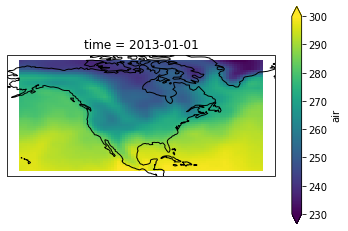

In [9]:
ax = plt.axes(projection=ccrs.PlateCarree())
dr_out.isel(time=0).plot.pcolormesh(ax=ax, vmin=230, vmax=300)
ax.coastlines()

## Check broadcasting over extra dimensions


xESMF tracks coordinate values over extra dimensions, since horizontal
regridding should not affect them.


In [10]:
dr_out["time"]

<xarray.DataArray 'time' (time: 2920)>
array(['2013-01-01T00:00:00.000000000', '2013-01-01T06:00:00.000000000',
       '2013-01-01T12:00:00.000000000', ..., '2014-12-31T06:00:00.000000000',
       '2014-12-31T12:00:00.000000000', '2014-12-31T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    standard_name:  time
    long_name:      Time

In [11]:
# exactly the same as input
xr.testing.assert_identical(dr_out["time"], ds["time"])

We can plot the time series at a specific location, to make sure the
broadcasting is correct:


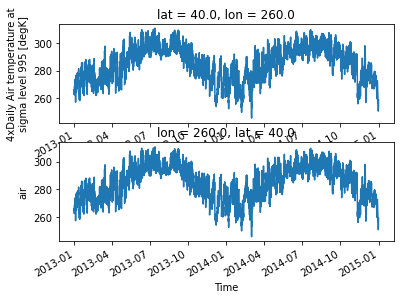

In [12]:
plt.subplot(2, 1, 1)
dr.sel(lon=260, lat=40).plot()  # input data
plt.subplot(2, 1, 2)
dr_out.sel(lon=260, lat=40).plot()  # output data